In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, AveragePooling2D
from keras.optimizers import Adam
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
%matplotlib inline
import json, datetime

In [2]:
#Dataset path
train_dir = '../../Dataset/metamorphic rocks/train'
val_dir = '../../Dataset/metamorphic rocks/test'

In [3]:
# hyperparameters
img_width, img_height = 299, 299
batch_size = 16
epochs = 20

In [4]:
# Data augmentation and preprocessing for the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,  
    vertical_flip=True  
    )
val_datagen = ImageDataGenerator(rescale=1./255,
                                 )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1085 images belonging to 13 classes.
Found 1085 images belonging to 13 classes.


In [5]:
class_labels = train_generator.class_indices
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_labels)
print(class_labels)
print(num_classes)
print(class_names)

{'Mariposite': 0, 'Schists': 1, 'anthracite': 2, 'gneiss': 3, 'hornfels': 4, 'lapis lazuli': 5, 'marble': 6, 'novaculite': 7, 'phyllite': 8, 'quartzite': 9, 'serpentine': 10, 'skarn': 11, 'slate': 12}
13
['Mariposite', 'Schists', 'anthracite', 'gneiss', 'hornfels', 'lapis lazuli', 'marble', 'novaculite', 'phyllite', 'quartzite', 'serpentine', 'skarn', 'slate']


In [6]:
#Model
xcep_model = Xception(weights='imagenet', include_top=False)
x = xcep_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(num_classes,activation='softmax')(x)
model = Model(inputs=xcep_model.input, outputs=predictions)

In [7]:
for layer in xcep_model.layers:
    layer.trainable = False

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [9]:
# Model compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               verbose=1, 
                               mode='auto')

In [11]:
now = datetime.datetime.now
t = now()
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping])

Epoch 1/20


2023-06-23 20:10:42.757246: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


67/67 [==============================] - 66s 969ms/step - loss: 1.9117 - accuracy: 0.4097 - val_loss: 1.3168 - val_accuracy: 0.5961
Epoch 2/20
67/67 [==============================] - 72s 1s/step - loss: 1.2270 - accuracy: 0.5921 - val_loss: 1.1136 - val_accuracy: 0.6409
Epoch 3/20
67/67 [==============================] - 78s 1s/step - loss: 1.0952 - accuracy: 0.6455 - val_loss: 0.9383 - val_accuracy: 0.7024
Epoch 4/20
67/67 [==============================] - 76s 1s/step - loss: 1.0232 - accuracy: 0.6810 - val_loss: 0.8493 - val_accuracy: 0.7136
Epoch 5/20
67/67 [==============================] - 79s 1s/step - loss: 0.9039 - accuracy: 0.6922 - val_loss: 0.7779 - val_accuracy: 0.7509
Epoch 6/20
67/67 [==============================] - 81s 1s/step - loss: 0.8637 - accuracy: 0.7063 - val_loss: 0.7610 - val_accuracy: 0.7640
Epoch 7/20
67/67 [==============================] - 81s 1s/step - loss: 0.8167 - accuracy: 0.7259 - val_loss: 0.6558 - val_accuracy: 0.7771
Epoch 8/20
67/67 [==========

In [12]:
print('Training time: %s' % (now() - t))

Training time: 0:36:31.914417


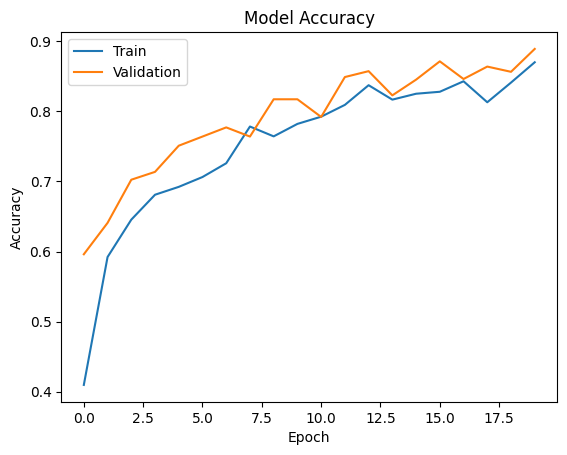

In [13]:
# Visualize training and validation accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

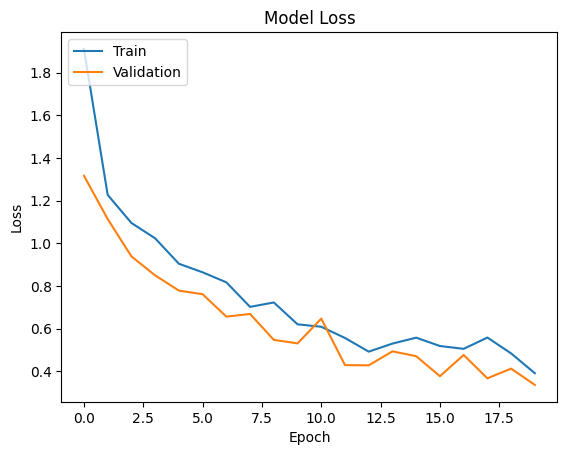

In [14]:
#Visualize training and validation loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print('Accuracy Loss:', val_loss)
print('Accuracy Rating:', val_accuracy)

68/68 [==============================] - 67s 993ms/step - loss: 0.3374 - accuracy: 0.8885
Accuracy Loss: 0.3373788893222809
Accuracy Rating: 0.8884792923927307


In [16]:
# Getting predict and actual labels
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
true_labels = val_generator.classes

68/68 [==============================] - 54s 789ms/step


In [17]:
# Confusion matrixi
cm = confusion_matrix(true_labels, y_pred)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[158   4   0   1   0   2   1   1   1   1   2  30   0]
 [  0  70   0   5   3   0   0   0   2   3   0   9   1]
 [  0   0  24   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0  35   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0  13   0   0   0   0   0   0   1   0]
 [  0   0   0   2   1 264   1   1   0   0   1   3   0]
 [  0   0   0   1   0   0  37   0   0   1   0   1   0]
 [  0   0   0   2   0   0   1  58   1   1   0   2   1]
 [  0   0   0   0   0   0   0   0  14   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0  36   0   3   0]
 [  0   0   0   0   1   0   0   0   2   0  30   6   0]
 [  0   1   0   4   4   1   1   0   1   2   2 160   0]
 [  0   0   0   0   0   0   0   0   0   0   1   2  65]]


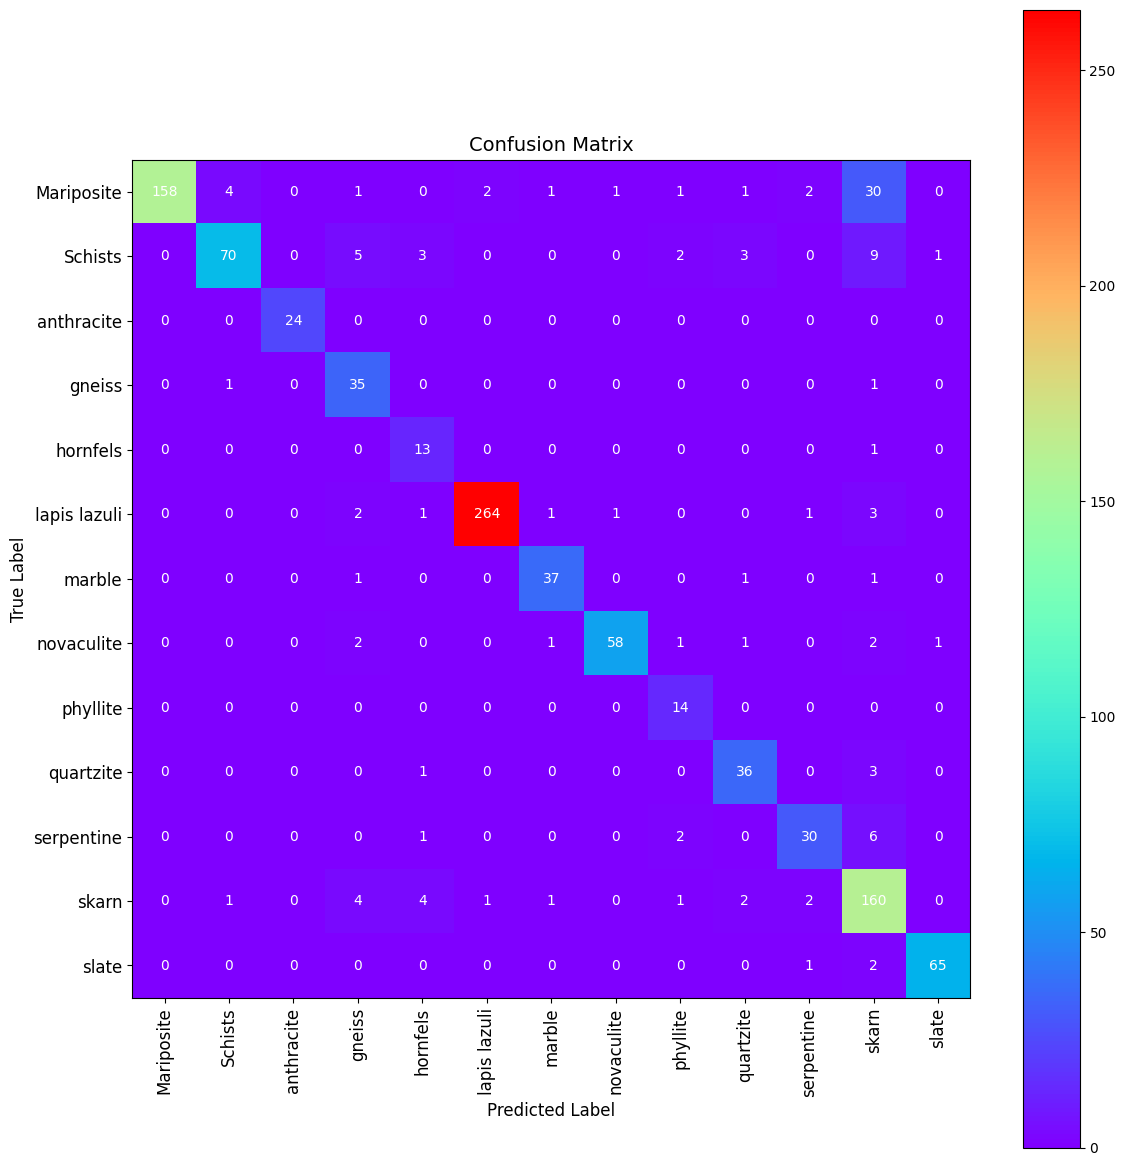

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(cm, cmap='rainbow')

# Renk çubuğu
cbar = plt.colorbar(im)

# Sınıf etiketleri
class_labels = [f'Class {i+1}' for i in range(num_classes)]
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_names, rotation=90, fontsize=12)
ax.set_yticklabels(class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Grid çizgileri
ax.grid(visible=False)

# Confusion matrix değerlerinin yazdırılması
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.tight_layout()
plt.show()

In [19]:
class_report = classification_report(true_labels, y_pred, target_names=class_names)
print('Class Raport:')
print(class_report)

Class Raport:
              precision    recall  f1-score   support

  Mariposite       1.00      0.79      0.88       201
     Schists       0.92      0.75      0.83        93
  anthracite       1.00      1.00      1.00        24
      gneiss       0.70      0.95      0.80        37
    hornfels       0.57      0.93      0.70        14
lapis lazuli       0.99      0.97      0.98       273
      marble       0.90      0.93      0.91        40
  novaculite       0.97      0.88      0.92        66
    phyllite       0.67      1.00      0.80        14
   quartzite       0.82      0.90      0.86        40
  serpentine       0.83      0.77      0.80        39
       skarn       0.73      0.91      0.81       176
       slate       0.97      0.96      0.96        68

    accuracy                           0.89      1085
   macro avg       0.85      0.90      0.87      1085
weighted avg       0.91      0.89      0.89      1085



In [20]:
# Save the model and results
model.save('xception_model.h5')
np.save('confusion_matrix.npy', cm)
with open('classification_report.txt', 'w') as f:
    f.write(class_report)

with open("history.json", "w") as f:
    json.dump(history.history, f)